# Parsing XML with lxml

XML is a general purpose markup language that was designed to exchange data among systems. There are hundreds of "XML schemas" that are used for particular applications or uses. 

## Getting some data

Let's get the XML file from the "US Overseas loans and grants" that was downloadable from here (it was retired august 2015): http://catalog.data.gov/dataset/us-overseas-loans-and-grants-greenbook-usaid-1554

In [14]:
# Code for getting the data:
# URL not available, instead the original file is provided with the Notebook. 
#from urllib import urlretrieve
#link = 'https://eads.usaid.gov/gbk/data/files/us_foreign_assistance.xml'
#urlretrieve(link, "fa.xml")

In [15]:
%ls -l *.xml

 El volumen de la unidad C es Windows8_OS
 El n£mero de serie del volumen es: A699-69CC

 Directorio de C:\Users\CarlosEduardo\CiffBigData\DataSciencePython\bloque3


 Directorio de C:\Users\CarlosEduardo\CiffBigData\DataSciencePython\bloque3

08/11/2016  18:18         2.583.173 fa.xml
               1 archivos      2.583.173 bytes
               0 dirs  321.400.119.296 bytes libres


In [16]:
!head -n12 fa.xml

"head" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


Note that this is a relatively simple XML. You can see a more complex one for example here: http://www.ec.tuwien.ac.at/~dorn/Courses/KM/Resources/hrxml/HR-XML-2_3/SIDES/StaffingInvoice.html

Information in XML is not necessarily tabular, but it can be complex and with a nested structure, so there is no single way of importing that into a tabular structure (DataFrame).

## Loading the XML into memory

In [17]:
from lxml import objectify
parsed = objectify.parse('fa.xml')
root = parsed.getroot()
print root.tag
print root.attrib
print root.countchildren()


ForeignAssistance
{}
8278


We can see in the XML file that it follows a simple structure with each entry as a ForeignAssistanceRow element.

The expression root.ForeignAssistanceRow generates one element for each ForeignAssistanceRow element:

In [18]:
country=[]
name=[]
unit =[]
year=[]
amount=[]
kind =[]
program = []
for row in root.ForeignAssistanceRow:
    country.append(row.RecipientCountry.text)
    name.append(row.ProgramName.text)
    unit.append(row.UnitName.text)
    year.append(row.FiscalYear.text)
    amount.append(row.Obligations.text)
    kind.append(row.AssistanceType.text)
    program.append(row.ProgramName.text)
    
print len(country), len(name), len(unit), len(year), len(amount)

8278 8278 8278 8278 8278


In [31]:
import pandas as pd
data = pd.DataFrame()
data['country'] = country
data['name'] = name
data['unit'] = unit
data['year'] = year
data['amount'] = amount
data['type'] = kind
data['program'] = program

# Always remember to check types and convert if needed:
print type(data['amount'][0])
data['amount'] = pd.Series(amount, dtype="int64") #convertir de int32 a int64
print type(data['amount'][0])

data.head(5)

<type 'str'>
<type 'numpy.int64'>


,country,name,unit,year,amount,type,program
0,Afghanistan,Child Survival and Health,Constant 2011 $US,2002,2691390,Economic,Child Survival and Health
1,Afghanistan,Child Survival and Health,Constant 2011 $US,2003,58817159,Economic,Child Survival and Health
2,Afghanistan,Child Survival and Health,Constant 2011 $US,2004,41877130,Economic,Child Survival and Health
3,Afghanistan,Child Survival and Health,Constant 2011 $US,2005,41467658,Economic,Child Survival and Health
4,Afghanistan,Child Survival and Health,Constant 2011 $US,2006,42463433,Economic,Child Survival and Health


## Some basic analysis

In [32]:
yearly = data.groupby(year)

In [33]:
per_year = yearly["amount"].sum()
print type(per_year)
per_year.head(5)

<class 'pandas.core.series.Series'>


1946    1047178817
1947    1499747351
1948    1491179787
1949    5034934326
1950    3812156866
Name: amount, dtype: int64

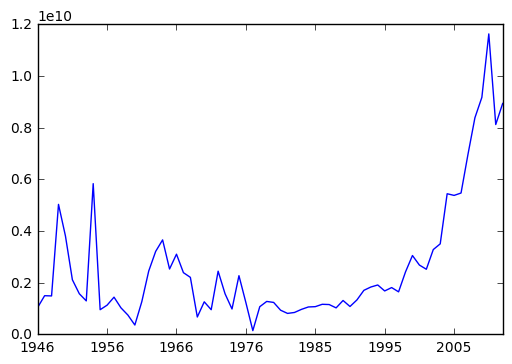

In [34]:
%matplotlib inline
per_year.plot()

Note: we have not checked that these are constant dollars!

<class 'pandas.core.groupby.DataFrameGroupBy'>
country
Afghanistan    52969366592
Albania         2099277602
Algeria         1522752781
Name: amount, dtype: int64
---------
country
Afghanistan             52969366592
Asia (not specified)    21667862209
Bangladesh              19205492546
Brazil                  18237524846
Bolivia                 14286340487
Name: amount, dtype: int64


C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


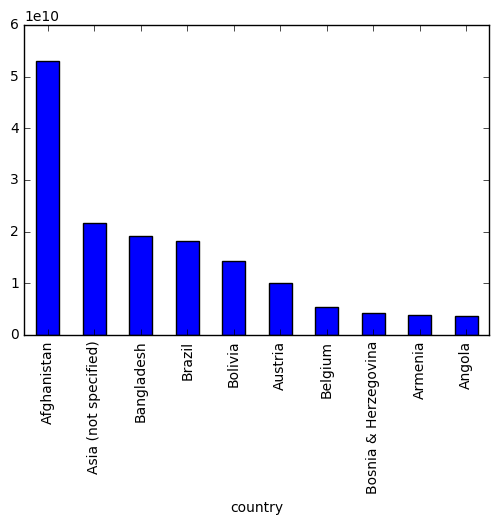

In [35]:
countrywise = data.groupby("country")
print type(countrywise)

per_country = countrywise["amount"].sum()
print per_country.head(3)
print "---------"

# Sort and visualize:
per_country.sort(ascending=False)
print per_country.head(5)
per_country.head(10).plot(kind="bar")

Now let's try to do that with homogeneous currency data.

{'Historical $US': array([   8,    9,   10, ..., 8275, 8276, 8277], dtype=int64), 'Constant 2011 $US': array([   0,    1,    2, ..., 8263, 8264, 8265], dtype=int64)}
                               amount
unit                                 
Constant 2011 $US count  4.156000e+03
                  mean   2.791793e+07
                  std    1.427025e+08
                  min   -5.742315e+07
                  25%    5.004238e+05
                  50%    2.520098e+06
                  75%    1.364326e+07
                  max    4.953482e+09
Historical $US    count  4.122000e+03
                  mean   1.450088e+07
                  std    8.024697e+07
                  min   -5.742315e+07
                  25%    3.000000e+05
                  50%    1.560000e+06
                  75%    7.745584e+06
                  max    2.655419e+09
----------------
<class 'pandas.core.frame.DataFrame'>
----------------
29


C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


country
Afghanistan             28590191083
Asia (not specified)    15560857192
Brazil                  15157110184
Bangladesh              12811248174
Bolivia                  9569419419
Austria                  8986074931
Belgium                  4774177381
Bosnia & Herzegovina     2448231674
Armenia                  2214524971
Angola                   2044264334
Name: amount, dtype: int64

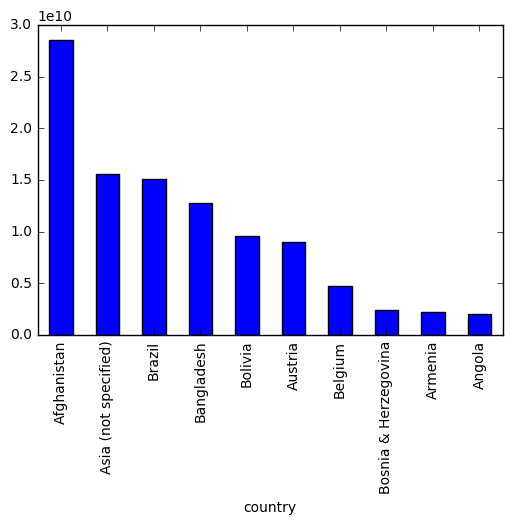

In [36]:
# Create groups based on unit:
currencywise = data.groupby("unit")
print currencywise.indices
print currencywise.describe()
print "----------------"


# Each group is a DataFrame:
constantdollars = currencywise.get_group("Constant 2011 $US")
print type(constantdollars)
print "----------------"


# Now we group by country:
percountry2 = constantdollars.groupby("country")
final = percountry2["amount"].sum()
final.sort(ascending=False)
print len(final)
final.head(10).plot(kind="bar")
final.head(10)

## Analyzing the type of assistance

We can get the different types of assistance:

In [37]:
programs = data["program"].unique()
print type(programs)
print len(programs)
programs

<type 'numpy.ndarray'>
21


array(['Child Survival and Health',
       'Department of Defense Security Assistance',
       'Development Assistance',
       'Economic Support Fund/Security Support Assistance',
       'Food For Education', 'Global HIV/AIDS Initiative',
       'Global Health and Child Survival', 'Inactive Programs',
       'Migration and Refugee Assistance', 'Narcotics Control',
       'Nonproliferation, Anti-Terrorism, Demining and Related',
       'Other Active Grant Programs', 'Other Food Aid Programs',
       'Other State Assistance', 'Other USAID Assistance',
       'Other USDA Assistance', 'Peace Corps', 'Title I', 'Title II',
       'Millennium Challenge Corporation',
       'Voluntary Contributions to Multilateral Organizations, Total'], dtype=object)

In [38]:
byprogram = data.groupby("program")
len(byprogram)
amountbyprogram = byprogram["amount"].sum()
amountbyprogram.sort(ascending=False)
amountbyprogram

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


program
Other USAID Assistance                                          51985444345
Economic Support Fund/Security Support Assistance               40940488143
Title II                                                        17942727220
Title I                                                         12525792327
Narcotics Control                                                9986684477
Inactive Programs                                                7423651460
Department of Defense Security Assistance                        6170454601
Development Assistance                                           5439410452
Voluntary Contributions to Multilateral Organizations, Total     3481346325
Other Food Aid Programs                                          3116251633
Global Health and Child Survival                                 2936038170
Migration and Refugee Assistance                                 2822740225
Other Active Grant Programs                                      2250997710
Mill

In [39]:
sixtop = amountbyprogram[:6]
sixtop

program
Other USAID Assistance                               51985444345
Economic Support Fund/Security Support Assistance    40940488143
Title II                                             17942727220
Title I                                              12525792327
Narcotics Control                                     9986684477
Inactive Programs                                     7423651460
Name: amount, dtype: int64

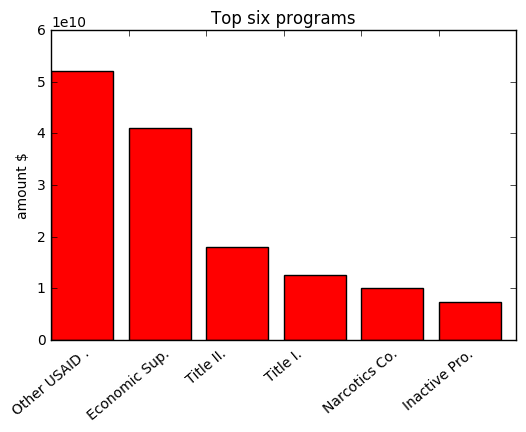

In [40]:

names = [name[:12]+"." for name in list(sixtop.index)]
pos = range(len(sixtop))


import matplotlib.pyplot as plt
line = plt.bar(pos, sixtop, color="r")
plt.xticks(pos, names, rotation=40)
plt.title("Top six programs")
plt.ylabel("amount $")
plt.savefig("programs.jpg", bbox_size=200)